In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost catboost lightgbm
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00


In [6]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from lightgbm.sklearn import LGBMClassifier
import catboost
from catboost import CatBoostClassifier

import tensorflow
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.compat.v1.disable_eager_execution()

from art.estimators.classification import KerasClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import SaliencyMapMethod

### Step 1: Load the Dataset

In [57]:
# Read the dataset
drebin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cs587/assignment4/data/dataset.csv')

# Display the shape of the dataset
print('Data shape', drebin.shape)

# Display the first 10 messages in the dataset
drebin.head(5)

Data shape (15036, 216)


<ipython-input-57-7df3b24baa43>:2: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  drebin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cs587/assignment4/data/dataset.csv')


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S


In [58]:
# Data Info
drebin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 216 entries, transact to class
dtypes: int64(214), object(2)
memory usage: 24.8+ MB


In [59]:
# Data Description
drebin.describe()

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
count,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,...,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000,15036.000000
mean,0.426443,0.446595,0.442671,0.413208,0.444932,0.486898,0.236632,0.330806,0.282389,0.312583,...,0.007050,0.233307,0.017425,0.004256,0.434424,0.666135,0.290835,0.016028,0.007050,0.044959
std,0.494576,0.497156,0.496719,0.492426,0.496975,0.499845,0.425029,0.470519,0.450177,0.463561,...,0.083669,0.422950,0.130852,0.065105,0.495698,0.471608,0.454163,0.125588,0.083669,0.207220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# Check Missing Values
drebin.isnull().sum().sort_values(ascending=False)

transact                       0
ACCOUNT_MANAGER                0
WRITE_SETTINGS                 0
REBOOT                         0
BLUETOOTH_ADMIN                0
                              ..
WAKE_LOCK                      0
RECEIVE_BOOT_COMPLETED         0
RESTART_PACKAGES               0
Ljava.lang.Class.getPackage    0
class                          0
Length: 216, dtype: int64

In [61]:
# Select the Non-numerical Features
drebin.select_dtypes(include='object').columns

Index(['TelephonyManager.getSimCountryIso', 'class'], dtype='object')

In [62]:
# Map Object Column into Numerical Column
dict_object_to_number = {'0':0, '1':1, 0:0, 1:1}

drebin['TelephonyManager.getSimCountryIso'] = drebin['TelephonyManager.getSimCountryIso'].map(dict_object_to_number)
drebin['TelephonyManager.getSimCountryIso'].dtype

dtype('float64')

In [63]:
# Check Missing Values
drebin.isnull().sum().sort_values(ascending=False)

TelephonyManager.getSimCountryIso    5
transact                             0
ACCOUNT_MANAGER                      0
REBOOT                               0
BLUETOOTH_ADMIN                      0
                                    ..
WAKE_LOCK                            0
RECEIVE_BOOT_COMPLETED               0
RESTART_PACKAGES                     0
Ljava.lang.Class.getPackage          0
class                                0
Length: 216, dtype: int64

In [64]:
# Delete Missing Value in TelephonyManager.getSimCountryIso
drebin.dropna(subset=['TelephonyManager.getSimCountryIso'], axis=0, inplace=True)
drebin.shape

(15031, 216)

### Step 2: Processing Data for Model

In [65]:
# Check the Value Counts of Column 'class'
drebin['class'].value_counts()

class
B    9476
S    5555
Name: count, dtype: int64

In [66]:
# Apply LabelEncoder on Target Column 'class'

label_encoder = LabelEncoder()
class_obj = drebin['class']
drebin['class'] = label_encoder.fit_transform(class_obj)

# Check the Value Counts of Column 'class' again
# to Make Sure the Conversion is Correct
drebin['class'].value_counts()

class
0    9476
1    5555
Name: count, dtype: int64

In [67]:
y = drebin['class']
X = drebin.drop('class', axis=1)

# Split y, X into Training Data and Test Data
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Scale X_train into Range [0,1]
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train_1)
X_test = min_max_scaler.transform(X_test_1)

# Display the Shape of Each Set
print(f'X_train shape: {X_train.shape}\ty_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}\ty_test shape: {y_test.shape}')

X_train shape: (12024, 215)	y_train shape: (12024,)
X_test shape: (3007, 215)	y_test shape: (3007,)


### Step3: Train ML Models

In [20]:
# Logistic Regression

# Create the Model and Train the Model
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

# Evaluate the Model on Test Data
lr_acc = lr_model.score(X_test, y_test)
print(f'accuracy is: {round(lr_acc,4) * 100}%')

# Print the Confusion Matrix
lr_y = lr_model.predict(X_test)
lr_cf_mtr = confusion_matrix(y_test, lr_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(lr_cf_mtr)

accuracy is: 98.2%

Confusion Matrix:
[[1077   34]
 [  20 1876]]


In [21]:
# Support Vector Machines

# Create the Model and Train the Model
lin_svm_model = LinearSVC()
lin_svm_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
lin_svm_acc = lin_svm_model.score(X_test, y_test)
print(f'accuracy is: {round(lin_svm_acc,4) * 100}%')

# Print the Confusion Matrix
lin_svm_y = lin_svm_model.predict(X_test)
lin_svm_cf_mtr = confusion_matrix(y_test, lin_svm_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(lin_svm_cf_mtr)

accuracy is: 97.94%

Confusion Matrix:
[[1078   33]
 [  29 1867]]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
# k Nearest Neighbors

# Create the Model and Train the Model
knn_model = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
knn_acc = knn_model.score(X_test, y_test)
print(f'accuracy is: {round(knn_acc,4) * 100}%')

# Print the Confusion Matrix
knn_y = knn_model.predict(X_test)
knn_cf_mtr = confusion_matrix(y_test, knn_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(knn_cf_mtr)

accuracy is: 97.84%

Confusion Matrix:
[[1077   34]
 [  31 1865]]


In [23]:
# Naïve Bayes

# Create the Model and Train the Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
nb_acc = nb_model.score(X_test, y_test)
print(f'accuracy is: {round(nb_acc,4) * 100}%')

# Print the Confusion Matrix
nb_y = nb_model.predict(X_test)
nb_cf_mtr = confusion_matrix(y_test, nb_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(nb_cf_mtr)

accuracy is: 70.44%

Confusion Matrix:
[[1083   28]
 [ 861 1035]]


In [24]:
# Decision Trees

# Create the Model and Train the Model
dctree_model = DecisionTreeClassifier(criterion='gini', max_depth=4)
dctree_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
dctree_acc = dctree_model.score(X_test, y_test)
print(f'accuracy is: {round(dctree_acc,4) * 100}%')

# Print the Confusion Matrix
dctree_y = dctree_model.predict(X_test)
dctree_cf_mtr = confusion_matrix(y_test, dctree_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(dctree_cf_mtr)

accuracy is: 92.72%

Confusion Matrix:
[[1027   84]
 [ 135 1761]]


In [25]:
# Random Forest

# Create the Model and Train the Model
rf_model = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=1, n_jobs=2)
rf_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
rf_acc = rf_model.score(X_test, y_test)
print(f'accuracy is: {round(rf_acc,4) * 100}%')

# Print the Confusion Matrix
rf_y = rf_model.predict(X_test)
rf_cf_mtr = confusion_matrix(y_test, rf_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(rf_cf_mtr)

accuracy is: 99.1%

Confusion Matrix:
[[1090   21]
 [   6 1890]]


In [26]:
# XGBoost

# Create the Model and Train the Model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
xgb_acc = xgb_model.score(X_test, y_test)
print(f'accuracy is: {round(xgb_acc,4) * 100}%')

# Print the Confusion Matrix
xgb_y = xgb_model.predict(X_test)
xgb_cf_mtr = confusion_matrix(y_test, xgb_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(xgb_cf_mtr)

accuracy is: 99.03999999999999%

Confusion Matrix:
[[1097   14]
 [  15 1881]]


In [27]:
# LightGBM

# Create the Model and Train the Model
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
lgbm_acc = lgbm_model.score(X_test, y_test)
print(f'accuracy is: {round(lgbm_acc,4) * 100}%')

# Print the Confusion Matrix
lgbm_y = lgbm_model.predict(X_test)
lgbm_cf_mtr = confusion_matrix(y_test, lgbm_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(lgbm_cf_mtr)

[LightGBM] [Info] Number of positive: 4444, number of negative: 7580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369594 -> initscore=-0.533958
[LightGBM] [Info] Start training from score -0.533958
accuracy is: 98.94%

Confusion Matrix:
[[1096   15]
 [  17 1879]]


In [28]:
# CatBoost

# Create the Model and Train the Model
catbst_model = CatBoostClassifier(verbose=False)
catbst_model.fit(X_train, y_train)

# Evaluate the Model on Test Data
catbst_acc = catbst_model.score(X_test, y_test)
print(f'accuracy is: {round(catbst_acc,4) * 100}%')

# Print the Confusion Matrix
catbst_y = catbst_model.predict(X_test)
catbst_cf_mtr = confusion_matrix(y_test, catbst_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(catbst_cf_mtr)

accuracy is: 99.27%

Confusion Matrix:
[[1096   15]
 [   7 1889]]


### Step 4: Deep Learning Network

In [29]:
# Define the Layers of the Network
inputs = Input(shape=(215,))

hidden = Dense(1024, activation='relu')(inputs)
hidden = Dropout(0.25)(hidden)
hidden = Dense(512, activation='relu')(hidden)
hidden = Dropout(0.25)(hidden)
hidden = Dense(256, activation='relu')(hidden)
hidden = Dropout(0.25)(hidden)
predictions = Dense(2, activation='softmax')(hidden)

# Create the Model
dnn_model = Model(inputs=inputs, outputs=predictions)

In [30]:
# Compile the Model
optimizer = tensorflow.keras.optimizers.legacy.Adam(learning_rate=1e-3)
dnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 215)]             0         
                                                                 
 dense (Dense)               (None, 1024)              221184    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0     

In [31]:
# Train the Model
callbacks = [EarlyStopping(monitor='val_accuracy', patience=30)]
history = dnn_model.fit(X_train, y_train, batch_size=256, epochs=300,
                     validation_split=0.2, verbose=0, callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


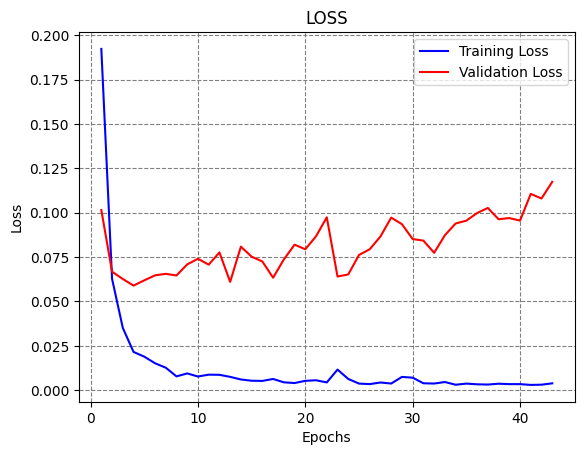

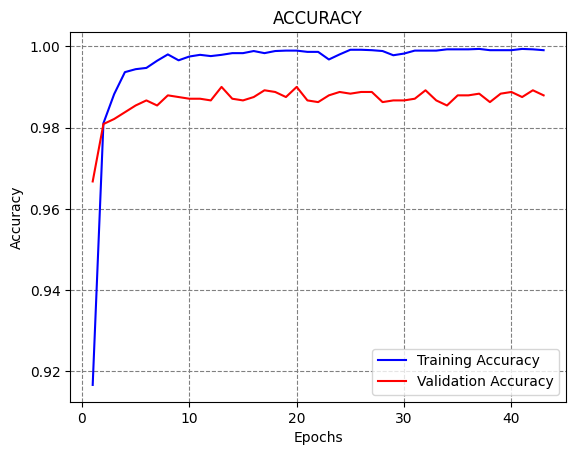

In [32]:
# Plot the Loss and Accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [33]:
# Evaluate on Test Data
dnn_acc = dnn_model.evaluate(X_test, y_test)
print("Classification Accuracy: ", dnn_acc[1])

Classification Accuracy:  0.991021


In [34]:
# Confusion Matrix
dnn_y = np.argmax(dnn_model.predict(X_test), axis=1)
dnn_cf_mtr = confusion_matrix(y_test, dnn_y ,labels=[1, 0])
print('\nConfusion Matrix:')
print(dnn_cf_mtr)


Confusion Matrix:
[[1103    8]
 [  19 1877]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


**Discuss the results, and compare the performance of the deep learning model and the ML models from Step 3:**
Deep learning model performes better than ML models in Step 3.

### Step 5: Apply Non-Targeted FGSM Attack on DL Model

In [68]:
# Randomly Select 1000 Samples from Test Set
np.random.seed(2)

ind_smpl = np.random.choice(len(X_test), size=1000)
X_test_1000 = X_test[ind_smpl]
y_test_1000 = y_test.values[ind_smpl]

print('Test image shape: {}\nTest label shape: {}'.format(X_test_1000.shape, y_test_1000.shape))

# Define the dnn Keras Classifier in ART
dnn_cls = KerasClassifier(model=dnn_model, clip_values=(0, 1))

# Define epsilon
epsilon = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5]

Test image shape: (1000, 215)
Test label shape: (1000,)


In [36]:
# Apply FGSM

atk_acc_fgsm = []
for eps in epsilon:
    atk_fgsm = FastGradientMethod(estimator=dnn_cls, eps=eps)

    adv_data_1000_fgsm = atk_fgsm.generate(X_test_1000)
    loss_fgsm, acc_fgsm = dnn_model.evaluate(adv_data_1000_fgsm, y_test_1000)
    atk_acc_fgsm.append(acc_fgsm)
    perturbation_fgsm = np.mean(np.abs((adv_data_1000_fgsm - X_test_1000)))

    print('Accuracy on adversarial test data: {:4.2f}%'.format(acc_fgsm * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation_fgsm))

Accuracy on adversarial test data: 98.90%
Average perturbation: 0.01
Accuracy on adversarial test data: 91.90%
Average perturbation: 0.01
Accuracy on adversarial test data: 76.30%
Average perturbation: 0.03
Accuracy on adversarial test data: 37.50%
Average perturbation: 0.05
Accuracy on adversarial test data: 10.50%
Average perturbation: 0.11
Accuracy on adversarial test data: 1.80%
Average perturbation: 0.16
Accuracy on adversarial test data: 1.40%
Average perturbation: 0.27


### Step 6: Apply Non-Targeted JSMA Attack on DL Model

In [41]:
# Apply JSMA
# in "class SaliencyMapMethod(EvasionAttack)" implementation, by default, gamma <= 1.0;
# here I change gamma from [1.0,  1.0,   1.0,  1.5, 1.5, 2.0, 2.0]
theta_list = [0.01, 0.025, 0.05, 0.2, 0.2, 0.3, 0.5]
gamma_list = [0.1,  0.1,   0.1,  0.5, 0.8, 0.8, 1.0]


atk_acc_jsma = []
for theta, gamma  in zip(theta_list,gamma_list):
    atk_jsma = SaliencyMapMethod(classifier=dnn_cls, theta=theta, gamma=gamma)

    adv_data_1000_jsma = atk_jsma.generate(X_test_1000)
    loss_jsma, acc_jsma = dnn_model.evaluate(adv_data_1000_jsma, y_test_1000)
    atk_acc_jsma.append(acc_jsma)
    perturbation_jsma = np.mean(np.abs((adv_data_1000_jsma - X_test_1000)))

    print(f'theta: {theta} and gamma: {gamma}')
    print('Accuracy on adversarial test data: {:4.2f}%'.format(acc_jsma * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation_jsma))

<ipython-input-41-d285867b40b9>:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  adv_data_1000_jsma = atk_jsma.generate(X_test_1000)


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.01 and gamma: 0.1
Accuracy on adversarial test data: 1.70%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.025 and gamma: 0.1
Accuracy on adversarial test data: 1.60%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.05 and gamma: 0.1
Accuracy on adversarial test data: 1.60%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.2 and gamma: 0.5
Accuracy on adversarial test data: 1.20%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.2 and gamma: 0.8
Accuracy on adversarial test data: 1.20%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.3 and gamma: 0.8
Accuracy on adversarial test data: 1.20%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

theta: 0.5 and gamma: 1.0
Accuracy on adversarial test data: 1.20%
Average perturbation: 0.02


**Discuss the results, interpret the impact of the different values of the parameters in JSMA on the performance, and compare the performance to the FGSM attack from Step 5.**

In JSMA attack, When we add almost the same amount pertubation as FGSM, accuracy on adversarial test data drops dramatically. In JSMA attack, when the mean pertubation is 0.02, the accuracy on adversarial test data is 1.7%; whereas in FGSM attack, when the mean pertubation is 0.03, the accuracy on adversarial test data is 76.3%;
It seems that when gamma is fixed, theta doesn't have much impact on test accuracy. When I keep gamma fixed at 0.1, theta changes from 0.01 to 0.05, the test accuracy doesn't change too much;

When increasing theta and gamma at the same time, the accuracy decreases.

### Step 7: Apply Non-Targeted on Logistic Regression and SVM

In [74]:
# Apply Non-Targeted on Logistic Regression
y_test_1000 = pd.Series(y_test_1000.flatten())

# Define the Keras Classifier in ART
lr_cls =  SklearnClassifier(model=lr_model, clip_values=(0, 1))

lr_atk_acc_fgsm = []
for eps in epsilon:
    lr_atk_fgsm = FastGradientMethod(estimator=lr_cls, eps=eps)

    lr_adv_data_1000_fgsm = lr_atk_fgsm.generate(X_test_1000)
    lr_acc_fgsm = lr_model.score(lr_adv_data_1000_fgsm, y_test_1000)
    lr_atk_acc_fgsm.append(lr_acc_fgsm)
    lr_perturbation_fgsm = np.mean(np.abs((lr_adv_data_1000_fgsm - X_test_1000)))

    print('Accuracy on adversarial test data: {:4.2f}%'.format(lr_acc_fgsm * 100))
    print('Average perturbation: {:4.2f}'.format(lr_perturbation_fgsm))


Accuracy on adversarial test data: 97.40%
Average perturbation: 0.01
Accuracy on adversarial test data: 93.80%
Average perturbation: 0.01
Accuracy on adversarial test data: 75.40%
Average perturbation: 0.03
Accuracy on adversarial test data: 35.40%
Average perturbation: 0.05
Accuracy on adversarial test data: 6.10%
Average perturbation: 0.10
Accuracy on adversarial test data: 1.90%
Average perturbation: 0.15
Accuracy on adversarial test data: 1.90%
Average perturbation: 0.26


In [77]:
# Apply Non-Targeted on SVM

# Define the Keras Classifier in ART
svm_cls = SklearnClassifier(model=lin_svm_model, clip_values=(0, 1))

svm_atk_acc_fgsm = []
for eps in epsilon:
    svm_atk_fgsm = FastGradientMethod(estimator=svm_cls, eps=eps)

    svm_adv_data_1000_fgsm = svm_atk_fgsm.generate(X_test_1000)
    svm_acc_fgsm = lin_svm_model.score(svm_adv_data_1000_fgsm, y_test_1000)
    svm_atk_acc_fgsm.append(svm_acc_fgsm)
    svm_perturbation_fgsm = np.mean(np.abs((svm_adv_data_1000_fgsm - X_test_1000)))

    print('Accuracy on adversarial test data: {:4.2f}%'.format(svm_acc_fgsm * 100))
    print('Average perturbation: {:4.2f}'.format(svm_perturbation_fgsm))

Accuracy on adversarial test data: 96.70%
Average perturbation: 0.01
Accuracy on adversarial test data: 81.20%
Average perturbation: 0.01
Accuracy on adversarial test data: 54.00%
Average perturbation: 0.03
Accuracy on adversarial test data: 18.00%
Average perturbation: 0.05
Accuracy on adversarial test data: 2.70%
Average perturbation: 0.10
Accuracy on adversarial test data: 2.20%
Average perturbation: 0.15
Accuracy on adversarial test data: 2.20%
Average perturbation: 0.25


**Discuss the results and compare the performance to the attacks against the deep learning model from Steps 5 and 6.**
FGSM attack on logistic regression model and svm model has similar behavior as FGSM attack on DL model. With almost the same amount of pertubation, test accuracy on FGSM attack is much higher than JSMA attack in step 6.  